### Initial package imports

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

## Initial files being read in and dataset creation

In [2]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)


### government bond column

In [3]:
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates


# Portfolio

### details
#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2022**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



### weights and currency correction

In [4]:
# initial investment 
weigths = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weigths['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weigths['DAX40']
invested_amount_NIKKEI = starting_investment * weigths['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weigths['EU-BOND']

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)


[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


### Returns Portfolio 

In [ ]:
#create a column for the invested amount in the SP500 and multiply by the return of the next day 
main_df['SP500_Investment'] = invested_amount_SP500 * (1 + main_df['C_S&P500_Returns']).cumprod()
main_df['DAX40_Investment'] = invested_amount_DAX40 * (1 + main_df['C_Dax40_Returns']).cumprod()
main_df['NIKKEI_Investment'] = invested_amount_NIKKEI * (1 + main_df['C_Nikkei_Returns']).cumprod()
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']


# Methods input values

### Expected returns (daily)

In [1]:
def expected_return(start, end):
    Mu_SP500 = main_df[(main_df['Date'] >= start) & (main_df['Date'] <= end)]['C_S&P500_Returns'].mean() 
    Mu_DAX40= main_df[(main_df['Date'] >= start) & (main_df['Date'] <= end)]['C_Dax40_Returns'].mean() 
    Mu_NIKKEI= main_df[(main_df['Date'] >= start) & (main_df['Date'] <= end)]['C_Nikkei_Returns'].mean() 
    Mu_EU_BOND= main_df[(main_df['Date'] >= start) & (main_df['Date'] <= end)]['Interest_Bond_daily_rate'].mean() 
    Mu= [Mu_SP500, Mu_DAX40, Mu_NIKKEI, Mu_EU_BOND]  
    return Mu


### Variances (daily)

In [2]:
def variances(start, end):
    var_SP500 = main_df[(main_df['Date'] >= start) & (main_df['Date'] <= end)]['C_S&P500_Returns'].var()
    var_DAX40 = main_df[(main_df['Date'] >= start) & (main_df['Date'] <= end)]['C_Dax40_Returns'].var()
    var_NIKKEI = main_df[(main_df['Date'] >= start) & (main_df['Date'] <= end)]['C_Nikkei_Returns'].var()
    var_EU_BOND = main_df[(main_df['Date'] >= start) & (main_df['Date'] <= end)]['Interest_Bond_daily_rate'].var()
    variances = [var_SP500, var_DAX40, var_NIKKEI, var_EU_BOND] 
    return variances

### Covariance matrix 

In [4]:
def covariance_matrix(start, end):
    df = main_df[(main_df['Date'] >= start) & (main_df['Date'] <= end)]
    returns = df[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']]
    cov_matrix = returns.cov()
    return cov_matrix

### Portfolio weighted variance & standard deviation

In [6]:
def var_p(start, end):
    weights = np.array([weigths['S&P500'], weigths['DAX40'], weigths['NIKKEI'], weigths['EU-BOND']])
    cov_matrix = covariance_matrix(start, end)
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return port_variance

# Value at Risk (VaR)

In [10]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)

        dVaR= r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0

    return dVaR

# Expected Shortfall (ES)

In [11]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0

    return dES

# performing different methods

write method for variance covariance where the sample period is an input parameter
alongside other parameters that are needed for the calculation

## 1. var/cov multivar normal dist


## 2. var/cov multivar on t-dist

## 3. historical simulation

# Main method

In [ ]:
def main():
    # Magic numbers
    vN = len(main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')])
    dMu = Pmu  #must be estimated via different methods
    dSy= Pvol #must be estimated via different methods
    vAlpha= [.95, .99]
    iDF= 6

    # Initialisation
    vAlpha= np.array(vAlpha)

    # Estimation
    vVaR= VaR(vAlpha, dMu, dSy)
    vVaRt= VaR(vAlpha, dMu, dSy, df= iDF)
    print ('var, vart:', vVaR, vVaRt)

    vES= ES(vAlpha, dMu, dSy)
    vESt= ES(vAlpha, dMu, dSy, df= iDF)
    print ('es, est:', vES, vESt)

    vN= dMu+dSy*st.norm.rvs(size= 10000000)
    print (f'Simulating Norm, mean= {vN.mean()}, std= {vN.std()}')

    dVaRs= np.quantile(vN, .95)
    vI= vN >= dVaRs
    print (f'Sim, var= {dVaRs}, ES= {vN[vI].mean()}')

    dS2t= iDF/(iDF-2)
    dC= dSy / np.sqrt(dS2t)
    vT= dMu+dC*st.t.rvs(df= iDF, size= 10000000)
    print (f'Simulating t({iDF}), mean= {vT.mean()}, std= {vT.std()}')

    dVaRt= np.quantile(vT, .95)
    vI= vT >= dVaRt
    print (f'Sim, vart= {dVaRt}, ES= {vT[vI].mean()}')

    np.quantile(vT, .99)
    VaR(.95, 0, 1)


# For Loop

In [14]:
def calculate_mean_return(window, current_date):
    """
    Calculate the mean returns for each index and the portfolio mean return.
    """
    return {
        'Date': current_date,
        'SP500_Mean_Return': window['C_S&P500_Returns'].mean(),
        'DAX40_Mean_Return': window['C_Dax40_Returns'].mean(),
        'NIKKEI_Mean_Return': window['C_Nikkei_Returns'].mean(),
        'EU_Bond_Mean_Return': window['Interest_Bond_daily_rate'].mean(),
        'Portfolio_Mean_Return': (
            weigths['S&P500'] * window['C_S&P500_Returns'].mean() +
            weigths['DAX40'] * window['C_Dax40_Returns'].mean() +
            weigths['NIKKEI'] * window['C_Nikkei_Returns'].mean() +
            weigths['EU-BOND'] * window['Interest_Bond_daily_rate'].mean()
        )
    }

In [15]:
def calculate_variance_return(window, current_date, weights):
    """
    Calculate the variance returns for each index and the portfolio variance and volatility.
    """
    variance_return = {
        'Date': current_date,
        'SP500_Var_Return': window['C_S&P500_Returns'].var(),
        'DAX40_Var_Return': window['C_Dax40_Returns'].var(),
        'NIKKEI_Var_Return': window['C_Nikkei_Returns'].var(),
        'EU_Bond_Var_Return': window['Interest_Bond_daily_rate'].var()
    }

    # Calculate the covariance matrix for the returns in the window
    covariance_matrix = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].cov()

    # Calculate the portfolio variance using the covariance matrix and weights
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix.values, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    # Add portfolio variance and volatility to the variance_return dictionary
    variance_return['Portfolio_Variance'] = portfolio_variance
    variance_return['Portfolio_Volatility'] = portfolio_volatility

    return variance_return

In [16]:
def calculate_VaR(Alpha, mean_return, variance_return, DF):
    if DF == 0:
        crit_val = st.norm.ppf(Alpha)
        VaR = mean_return['Portfolio_Mean_Return'] + variance_return['Portfolio_Volatility'] * crit_val
    else:
        crit_val = st.t.ppf(Alpha, df=DF)
        scale = variance_return['Portfolio_Volatility'] / np.sqrt(DF / (DF - 2))
        VaR = mean_return['Portfolio_Mean_Return'] + scale * crit_val
    return VaR

In [17]:
def calculate_ES(vAlpha, mean_return, variance_return, DF):
    if DF == 0:
        crit_val = st.norm.ppf(vAlpha)
        crit_val_ES = st.norm.pdf(crit_val) / (1 - vAlpha)
            
        ES_value = mean_return['Portfolio_Mean_Return'] + variance_return['Portfolio_Volatility'] * crit_val_ES
    else:
        crit_val = st.t.ppf(vAlpha, df=DF)
        crit_val_ES = st.t.pdf(crit_val, df=DF) * ((DF + crit_val ** 2) / (DF - 1)) / (1 - vAlpha) 
        scale = variance_return['Portfolio_Volatility'] / np.sqrt(DF / (DF - 2))
            
        ES_value = mean_return['Portfolio_Mean_Return'] + scale * crit_val_ES

    return ES_value

In [18]:
# Initialize lists to store results
mean_returns = []
variance_returns = []
VaR_results = []
ES_results = []  # List to store VaR results
time_window = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]

vAlpha= [.95, .99]
DF= 0

# Initialisation
vAlpha= np.array(vAlpha)

# Iterate through the DataFrame with a rolling window of 500 days
sample_size = 500

for i in range(sample_size, len(time_window)):
    # Extract the window of 500 days
    window = time_window.iloc[i - sample_size:i]
    current_date = time_window.iloc[i]['Date']
    
    # Calculate mean and variance returns using the functions
    mean_return = calculate_mean_return(window, current_date)
    variance_return = calculate_variance_return(window, current_date, weights)
    
    # Append the results to the lists
    mean_returns.append(mean_return)
    variance_returns.append(variance_return)
    
    # Calculate VaR
    VaR0 = calculate_VaR(vAlpha, mean_return, variance_return, 0)
    VaR3 = calculate_VaR(vAlpha, mean_return, variance_return, 3)
    VaR4 = calculate_VaR(vAlpha, mean_return, variance_return, 4)
    VaR5 = calculate_VaR(vAlpha, mean_return, variance_return, 5)
    VaR6 = calculate_VaR(vAlpha, mean_return, variance_return, 6)

    ES0 = calculate_ES(vAlpha, mean_return, variance_return, 0)
    ES3 = calculate_ES(vAlpha, mean_return, variance_return, 3)
    ES4 = calculate_ES(vAlpha, mean_return, variance_return, 4)
    ES5 = calculate_ES(vAlpha, mean_return, variance_return, 5)
    ES6 = calculate_ES(vAlpha, mean_return, variance_return, 6)
    
    # Append VaR results to the same index
    
    VaR_results.append({
        'Date': current_date,
        'VaR Normal': VaR0,
        'VaR T3': VaR3,
        'VaR T4': VaR4,
        'VaR T5': VaR5,
        'VaR T6': VaR6
    })
    
    ES_results.append({
        'Date': current_date,
        'ES Normal': ES0,
        'ES T3': ES3,
        'ES T4': ES4,
        'ES T5': ES5,
        'ES T6': ES6
    })

# Convert the results to DataFrames for easier analysis
mean_returns_df = pd.DataFrame(mean_returns)
variance_returns_df = pd.DataFrame(variance_returns)
var_results_df = pd.DataFrame(VaR_results)
es_results_df = pd.DataFrame(ES_results)

# Display the results
display(var_results_df.head())
display(es_results_df.head())


,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6
0,2013-12-17,"[0.008602923098597772, 0.011966379949309077]","[0.007190710322248997, 0.013423453323561547]","[0.007924746219772993, 0.013561229818344591]","[0.008188329155127207, 0.013348867121458668]","[0.008315417553343406, 0.013149054070694307]"
1,2013-12-18,"[0.008592071646998692, 0.011954297901457281]","[0.007180375560421111, 0.013410838172680968]","[0.007914142894421047, 0.013548564258838092]","[0.008177629392036673, 0.013336279259615795]","[0.008304671292107196, 0.013136539314945083]"
2,2013-12-19,"[0.00862683729572483, 0.01199694272267383]","[0.007211832985331125, 0.01345689630732965]","[0.007947319858396806, 0.01359494514618309]","[0.008211423820575043, 0.013382162669991841]","[0.008338763435602388, 0.01318195464692361]"
3,2013-12-20,"[0.00864487691337611, 0.01201621656108816]","[0.007229354391390056, 0.013476704818936355]","[0.007965110618987624, 0.013614804214885687]","[0.00822931130294528, 0.01340194381218566]","[0.008356697553070615, 0.013201662467702312]"
4,2013-12-23,"[0.008656314495360792, 0.012028430943841982]","[0.007240465818463423, 0.013489255717295414]","[0.007976391573923273, 0.013627386933152618]","[0.008240653133175601, 0.01341447748463051]","[0.00836806873475983, 0.013214149992704692]"


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6
0,2013-12-17,"[0.010665231517892806, 0.013638825958681596]","[0.011524470403511797, 0.020439911959279224]","[0.011662474406968527, 0.01870402382238797]","[0.011533723621353171, 0.017506328304870897]","[0.011408485059072871, 0.016734963936047904]"
1,2013-12-18,"[0.010653625524426422, 0.01362613200888387]","[0.01151255003819533, 0.020424729679374046]","[0.011650503549786981, 0.01868947665615638]","[0.011521799870539074, 0.01749221934245198]","[0.011396607129600412, 0.016721137194612896]"
2,2013-12-19,"[0.010693222299129578, 0.013672694671527747]","[0.011554159650193794, 0.02048722444166996]","[0.011692436447439418, 0.018747904958657587]","[0.011563431158956382, 0.01754784194534342]","[0.011437945036452722, 0.016774952813444582]"
3,2013-12-20,"[0.0107120186810219, 0.013692582214140308]","[0.011573271329864599, 0.020509607643339787]","[0.01171159876769044, 0.01876965117603537]","[0.01158254623409622, 0.017569148668254306]","[0.011457014155292017, 0.016795976484138022]"
4,2013-12-23,"[0.010723932559518598, 0.013705182853476]","[0.011585383652241165, 0.020523779014535806]","[0.01172374296251871, 0.018783421638493825]","[0.011594660693532084, 0.017582642519226276]","[0.011469099690494327, 0.01680929218612174]"


## Historical simulation

VaR (S&P500) at 95.0% confidence level: 31.027729599999944
ES (S&P500) at 95.0% confidence level: 59.257054484375004


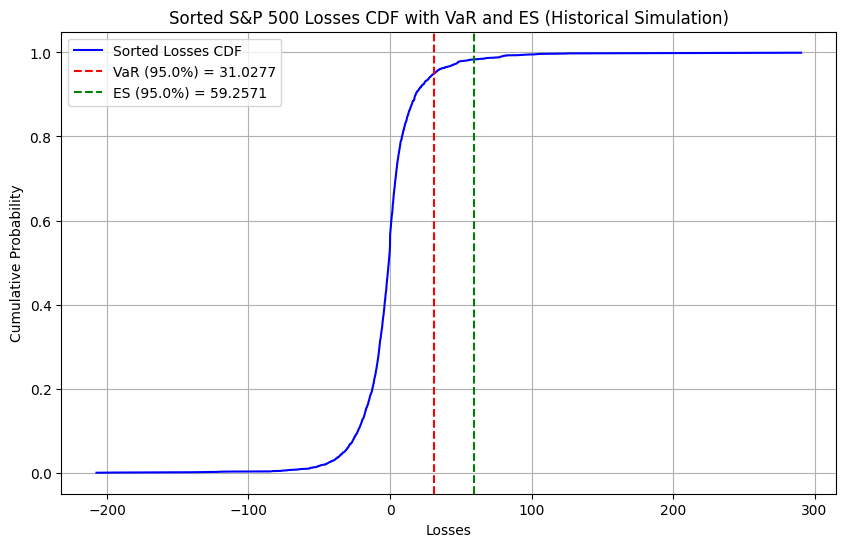

In [26]:
# Define the confidence level
confidence_level = 0.95

# Extract historical losses for S&P500 for the specified period
sp500_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Loss']

# Sort the losses in ascending order (smallest loss first, largest loss last)
sorted_losses = sp500_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_sp500 = sorted_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_sp_losses = sorted_losses[sorted_losses >= VaR_sp500]
ES_sp500 = tail_sp_losses.mean()

print(f"VaR (S&P500) at {confidence_level * 100}% confidence level: {VaR_sp500}")
print(f"ES (S&P500) at {confidence_level * 100}% confidence level: {ES_sp500}")

# Plot the sorted losses (Empirical Cumulative Distribution Function - CDF)
plt.figure(figsize=(10, 6))
# Plotting the empirical CDF: x-axis is loss value, y-axis is cumulative probability
plt.plot(sorted_losses.values, np.linspace(0, 1, len(sorted_losses), endpoint=False), label='Sorted Losses CDF', color='blue')

# Highlight VaR and ES on the graph
# VaR is the loss value at the confidence level percentile
plt.axvline(x=VaR_sp500, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%) = {VaR_sp500:.4f}')
# ES is the average loss in the tail beyond VaR
plt.axvline(x=ES_sp500, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%) = {ES_sp500:.4f}')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Cumulative Probability') # Changed from 'Probability' to be more precise for CDF
plt.title('Sorted S&P 500 Losses CDF with VaR and ES (Historical Simulation)')
plt.legend()
plt.grid(True) # Changed grid() to grid(True) for clarity
plt.show()

In [43]:
# # Define the confidence level, DIT IS NOG GEEN VASTE WAARDE, MEER VOOR GEMAK NU
# confidence_level = 0.95

# # Extract historical losses for S&P500
# sp500_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Loss']

# # Sort the losses in ascending order
# sorted_losses = sp500_losses.sort_values()

# # Calculate the index for the VaR based on the confidence level
# var_index = int((1 - confidence_level) * len(sorted_losses))

# # Calculate VaR
# VaR_sp500 = sorted_losses.iloc[var_index]

# # Calculate ES (average of losses beyond VaR)
# ES_sp500 = sorted_losses.iloc[:var_index].mean()

# print(f"VaR (S&P500) at {confidence_level * 100}% confidence level: {VaR_sp500}")
# print(f"ES (S&P500) at {confidence_level * 100}% confidence level: {ES_sp500}")

# # Plot the sorted losses as a line graph
# plt.figure(figsize=(10, 6))
# plt.plot(sorted_losses.values, np.linspace(0, 1, len(sorted_losses), endpoint=False), label='Sorted Losses', color='blue')

# # Highlight VaR and ES on the graph
# plt.axvline(x=VaR_sp500, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
# plt.axvline(x=ES_sp500, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# # Add labels, title, and legend
# plt.xlabel('Losses')
# plt.ylabel('Probability')
# plt.title('Sorted Losses with VaR and ES')
# plt.legend()
# plt.grid()
# plt.show()


VaR (DAX40) at 95.0% confidence level: 199.3679999999997
ES (DAX40) at 95.0% confidence level: 314.866953125


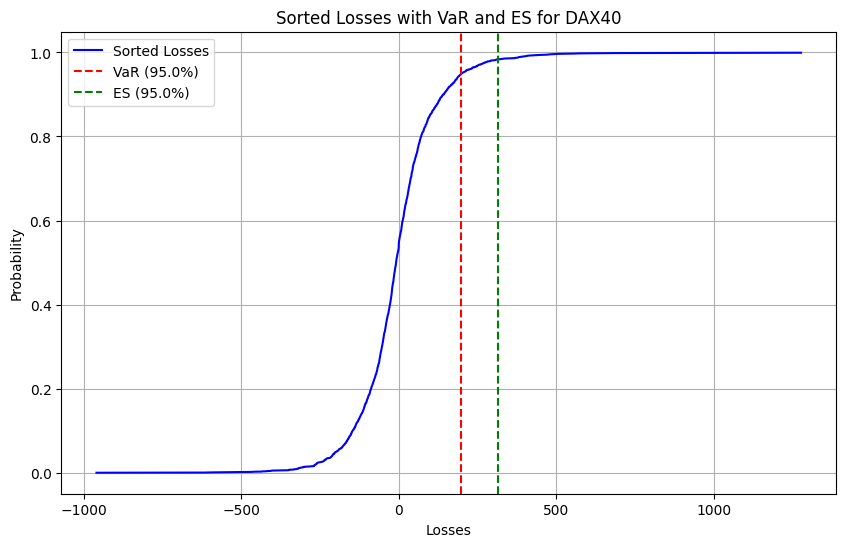

In [27]:
confidence_level = 0.95
# Extract historical losses for DAX40
dax40_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Loss']

# Sort the losses in ascending order
sorted_dax40_losses = dax40_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_dax40 = sorted_dax40_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_dax_losses = sorted_dax40_losses[sorted_dax40_losses >= VaR_dax40]
ES_dax40 = tail_dax_losses.mean()

print(f"VaR (DAX40) at {confidence_level * 100}% confidence level: {VaR_dax40}")
print(f"ES (DAX40) at {confidence_level * 100}% confidence level: {ES_dax40}")

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_dax40_losses.values, np.linspace(0, 1, len(sorted_dax40_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_dax40, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_dax40, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for DAX40')
plt.legend()
plt.grid()
plt.show()

In [45]:
# confidence_level = 0.95
# # Extract historical losses for DAX40
# dax40_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Loss']

# # Sort the losses in ascending order
# sorted_dax40_losses = dax40_losses.sort_values()

# # Calculate the index for the VaR based on the confidence level
# var_index_dax40 = int((1 - confidence_level) * len(sorted_dax40_losses))

# # Calculate VaR
# VaR_dax40 = sorted_dax40_losses.iloc[var_index_dax40]

# # Calculate ES (average of losses beyond VaR)
# ES_dax40 = sorted_dax40_losses.iloc[:var_index_dax40].mean()

# print(f"VaR (DAX40) at {confidence_level * 100}% confidence level: {VaR_dax40}")
# print(f"ES (DAX40) at {confidence_level * 100}% confidence level: {ES_dax40}")

# # Plot the sorted losses as a line graph
# plt.figure(figsize=(10, 6))
# plt.plot(sorted_dax40_losses.values, np.linspace(0, 1, len(sorted_dax40_losses), endpoint=False), label='Sorted Losses', color='blue')

# # Highlight VaR and ES on the graph
# plt.axvline(x=VaR_dax40, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
# plt.axvline(x=ES_dax40, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# # Add labels, title, and legend
# plt.xlabel('Losses')
# plt.ylabel('Probability')
# plt.title('Sorted Losses with VaR and ES for DAX40')
# plt.legend()
# plt.grid()
# plt.show()

VaR (Nikkei) at 95.0% confidence level: 3.0092212339999986
ES (Nikkei) at 95.0% confidence level: 4.61174921890625


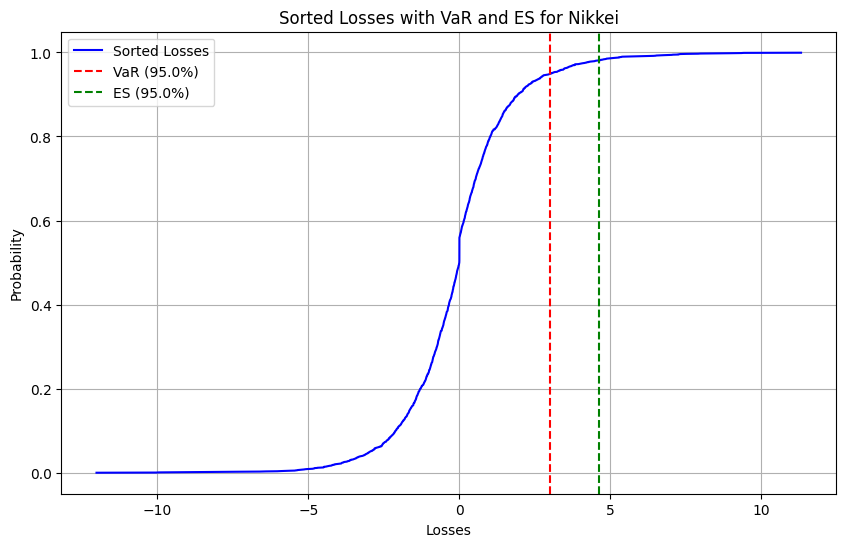

In [28]:
confidence_level = 0.95

# Extract historical losses for Nikkei
nikkei_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Loss']

# Sort the losses in ascending order
sorted_nikkei_losses = nikkei_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_nikkei = sorted_nikkei_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_nik_losses = sorted_nikkei_losses[sorted_nikkei_losses >= VaR_nikkei]
ES_nikkei = tail_nik_losses.mean()

print(f"VaR (Nikkei) at {confidence_level * 100}% confidence level: {VaR_nikkei}")
print(f"ES (Nikkei) at {confidence_level * 100}% confidence level: {ES_nikkei}")

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_nikkei_losses.values, np.linspace(0, 1, len(sorted_nikkei_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_nikkei, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_nikkei, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for Nikkei')
plt.legend()
plt.grid()
plt.show()

In [25]:
# confidence_level = 0.95

# # Extract historical losses for Nikkei
# nikkei_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Loss']

# # Sort the losses in ascending order
# sorted_nikkei_losses = nikkei_losses.sort_values()

# # Calculate the index for the VaR based on the confidence level
# var_index_nikkei = int((1 - confidence_level) * len(sorted_nikkei_losses))

# # Calculate VaR
# VaR_nikkei = sorted_nikkei_losses.iloc[var_index_nikkei]

# # Calculate ES (average of losses beyond VaR)
# ES_nikkei = sorted_nikkei_losses.iloc[:var_index_nikkei].mean()

# print(f"VaR (Nikkei) at {confidence_level * 100}% confidence level: {VaR_nikkei}")
# print(f"ES (Nikkei) at {confidence_level * 100}% confidence level: {ES_nikkei}")

# # Plot the sorted losses as a line graph
# plt.figure(figsize=(10, 6))
# plt.plot(sorted_nikkei_losses.values, np.linspace(0, 1, len(sorted_nikkei_losses), endpoint=False), label='Sorted Losses', color='blue')

# # Highlight VaR and ES on the graph
# plt.axvline(x=VaR_nikkei, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
# plt.axvline(x=ES_nikkei, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# # Add labels, title, and legend
# plt.xlabel('Losses')
# plt.ylabel('Probability')
# plt.title('Sorted Losses with VaR and ES for Nikkei')
# plt.legend()
# plt.grid()
# plt.show()